In [1]:
%load_ext autoreload
%autoreload 2

from model_utils import train_model, split_data, split_branches, get_model, set_pretrained_model_dropout, get_dataset, ModelSeeder
from config import Config
import json
import matplotlib.pyplot as plt
%matplotlib inline
import math
import random
import time
import onnx
from onnx_model_manager import OnnxModelManager
from onnxruntime.quantization import quantize_dynamic, QuantType
import os
import datasets
import torch
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
from model_manager import ModelManager

In [2]:
# seed = random.randint(0, 2 ** 32 - 1)
seed = 3218885689
random.seed(seed)
datasets.logging.set_verbosity(datasets.logging.ERROR)
# Tell pytorch to run this model on the GPU.
device_name = "cuda:0" if torch.cuda.is_available() else "cpu"
# device_name = "cpu"
device = torch.device(device_name)
print(f"Will use {device_name} for training with seed: {seed}")

Will use cuda:0 for training with seed: 3218885689


In [3]:
split_data(os.path.join(Config.work_dir, "awsw_story_input.txt"))

In [4]:
config = {
    "lr": 6e-4,
    "warmup_factor": 0,
    "scheduler": "polynomial_decay_schedule_with_warmup",
    "lr_end": 2e-6,
    "power": 0.6,
    #"freeze_layer_rate": 1e-4,
    "freeze_from_steps": -1,
    "seed": seed,
    "num_epoch": 300
}

optuna_result_attachement = {
    'lr': 0.001,
    'scheduler': 'cosine_schedule_with_warmup',
    'to_freeze_count': 0,
    #"to_freeze_gpt_blocks": 11,
    'warmup_factor': 1
}
config.update(optuna_result_attachement)

In [5]:
saved_model_path = os.path.join("models", "awsw_main")
if os.path.exists(os.path.join(saved_model_path, "pytorch_model.bin")):
    tokenizer = AutoTokenizer.from_pretrained('EleutherAI/gpt-neo-125M')
    model = AutoModelForCausalLM.from_pretrained(saved_model_path)
    print("Pretrained model loaded")
else:
    model, tokenizer = get_model("EleutherAI/gpt-neo-125M")
    print("Loaded empty model")
model.to(device)
# set_pretrained_model_dropout(model.transformer.h[-1:], 0.05)

Loaded empty model


GPTNeoForCausalLM(
  (transformer): GPTNeoModel(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(2048, 768)
    (drop): Dropout(p=0, inplace=False)
    (h): ModuleList(
      (0): GPTNeoBlock(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPTNeoAttention(
          (attention): GPTNeoSelfAttention(
            (attn_dropout): Dropout(p=0, inplace=False)
            (resid_dropout): Dropout(p=0, inplace=False)
            (k_proj): Linear(in_features=768, out_features=768, bias=False)
            (v_proj): Linear(in_features=768, out_features=768, bias=False)
            (q_proj): Linear(in_features=768, out_features=768, bias=False)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPTNeoMLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (c_proj): Linear(in_features=3072, o

# Test before training on a pretrained model!

In [6]:
model.eval()
model_manager = ModelManager(model=model, tokenizer=tokenizer, device=device)
def test_regular_sampler():
    print(model_manager.say_raw("In my dreams, I'm a dragon", 50, 0.7))
test_regular_sampler()

In my dreams, I'm a dragon-god. I'm the dragon-god of the dragons, and I'm the dragon-god of the gods.

A dragon is a god, a god-god. A dragon-god is a god, a god-god.

I am the dragon-god of the gods, and I'm the dragon-god of the gods.

I am the dragon-god of the gods, and I'm the dragon-god of the gods.

My god is a dragon, a god-god. A god-god is a god, a god-


# Reviewing our dataset!

In [7]:
dataset = get_dataset(tokenizer, path_train = os.path.join(Config.work_dir, "data_train.txt"))
print("Dataset demo snapshot:")
for item in dataset['train']:
    print(tokenizer.decode(item['input_ids']))
    break

print("RP review!")
has_seen_rp = False
for item in dataset['train']:
    decoded = tokenizer.decode(item['input_ids'])
    if 'c "Fight ' in decoded: 
        print(decoded)
        has_seen_rp = True
        continue        
    if has_seen_rp:
        print(decoded)
        break
# Clean up
del has_seen_rp
# dataset['model_seeder'].stop_worker()
# del dataset

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Dataset text downloaded and prepared to /home/awsw-dev/.cache/huggingface/datasets/text/default-62627411737808a5/0.0.0/e16f44aa1b321ece1f87b07977cc5d70be93d69b20486d6dacd62e12cf25c9a5. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (2159 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2085 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3376 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2083 > 2048). Running this sequence through the model will result in indexing errors


Dataset demo snapshot:


Token indices sequence length is longer than the specified maximum sequence length for this model (2085 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2159 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3376 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2083 > 2048). Running this sequence through the model will result in indexing errors


<d><scn>black<msg>n "Without electrical power, the quality of health care plummeted, and water and sewage systems were crippled. Diseases we thought defeated centuries ago made their comeback in a most unsightly fashion."<|endoftext|><d><scn>facin3<msg>m "At the bottom of the door, the corner of an envelope was noticeably sticking out."<|endoftext|><d><scn>np2x<msg>Ad "..."<|endoftext|><p><msg>c "They changed their minds, so I suppose you'll be stuck with me for a little while longer."<|endoftext|><p><
RP review!


Token indices sequence length is longer than the specified maximum sequence length for this model (2159 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2083 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3376 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2085 > 2048). Running this sequence through the model will result in indexing errors


# Training

Model is put in training mode and we begin training. The `train_results` will contain all data after training is completed.

In [8]:
train_results = {}
model.train()
train_model(model, tokenizer, dataset, config, train_results)

[0] set freeze_part_layers: True (freezing 0 out of 160 layers.)


Step,Training Loss
312,1.278400
624,0.739400
936,0.650800
1248,0.656800
1560,0.645000
1872,0.632200
2184,0.631900
2496,0.629500
2808,0.719800
3120,0.649400


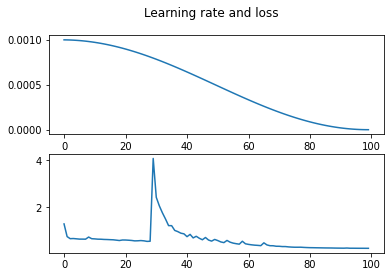

In [9]:
fig, axs = plt.subplots(2)
fig.suptitle('Learning rate and loss')
axs[0].plot(train_results['learning_rate_history'])
axs[1].plot(train_results['loss_history'])

In [10]:
model.eval()
model.save_pretrained(saved_model_path)

# Conversion to ONNX
ONNX is a different format for running machine learning models. The ONNX format is much faster on CPU, sometimes 5 times as fast as PyTorch!

While the EAWSW model is designed to be small, accurate and accessible, for some people it's still too much to run...

Hosting the model as a free service for players is an option. An ONNX version of the model allows us to host the model on CPU yet have faster response times! Given that the model is made in a time with chip shortage, running on hardware I already have inside a server is efficient, scalable and cheaper.

An important note is that ONNX doesn't execute logic by itself, and you have to do that yourself, `onnx_model_manager.py` intends to deal with this for us.

In [11]:
saved_model_onnx_path = os.path.join("models", "awsw_onnx")
if not os.path.exists(os.path.join(saved_model_path, "special_tokens_map.json")):
    print("Copying config files from huggingface (needed for conversion)... WARNING: this assumes the structure of the model isn't changed!")
    !cd $saved_model_path && git clone https://huggingface.co/EleutherAI/gpt-neo-125M
    !cp -n $saved_model_path/gpt-neo-125M/* $saved_model_path
    !rm -rf $saved_model_path/gpt-neo-125M
if not os.path.exists(os.path.join(saved_model_onnx_path, "model.onnx")):
    !python3 -m transformers.onnx --model=$saved_model_path --feature=causal-lm-with-past $saved_model_onnx_path

Copying config files from huggingface (needed for conversion)... WARNING: this assumes the structure of the model isn't changed!
Cloning into 'gpt-neo-125M'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 38 (delta 16), reused 0 (delta 0)
Unpacking objects: 100% (38/38), 542.60 KiB | 907.00 KiB/s, done.
Using framework PyTorch: 1.10.0+cu113
Overriding 1 configuration item(s)
	- use_cache -> True
/usr/local/lib/python3.8/dist-packages/torch/onnx/utils.py:90: UserWarning: 'enable_onnx_checker' is deprecated and ignored. It will be removed in the next PyTorch release. To proceed despite ONNX checker failures, catch torch.onnx.ONNXCheckerError.
  warnings.warn("'enable_onnx_checker' is deprecated and ignored. It will be removed in "
/usr/local/lib/python3.8/dist-packages/torch/onnx/utils.py:103: UserWarning: `use_external_data_format' is deprecated and ignored. Will be removed in next PyT

In [12]:
def optimize_onnx():
    model_quant = os.path.join(saved_model_onnx_path, "model_quant.onnx")
    if not os.path.exists(model_quant):
        model_fp32 = os.path.join(saved_model_onnx_path, "model.onnx")
        model_opt = os.path.join(saved_model_onnx_path, "model-opt.onnx")
        quantized_model = quantize_dynamic(model_fp32, model_quant, weight_type=QuantType.QUInt8)
        !rm $model_opt
optimize_onnx()

In [13]:
onnx_model_manager = OnnxModelManager(os.path.join(saved_model_onnx_path, "model_quant.onnx"))

In [14]:
prompt = "In my dreams, I'm a dragon"
for i in range(10):
    print("ONNX:", onnx_model_manager.say_raw(prompt, do_sample=True))
    print("PyTorch:", model_manager.say_raw(prompt, 50, 0.7))
    print('-' * 100)

ONNX: In my dreams, I'm a dragon bit... With its distinct lack a river shape than playing all of theantasy."<|endoftext|>
PyTorch: In my dreams, I'm a dragon"."<d><scn>np2x<msg>Ad "Now, with all that's happened, I don't know what to think anymore."<d><scn>np2x<msg>m "She looked disappointed. Not just in me, but probably my entire race."<d><scn>np2x<msg>Ad "Goodbye, [player_name]."<p><msg>c "Goodbye, Adine."<|endoftext|>
----------------------------------------------------------------------------------------------------
ONNX: In my dreams, I'm a dragon, there. No one else to run."<|endoftext|>
PyTorch: In my dreams, I'm a dragon"."<d><scn>np3<msg>m "As I returned to them, I heard Bryce audibly gasping."<d><scn>np3<msg>Br "Damn it."<|endoftext|>
----------------------------------------------------------------------------------------------------
ONNX: In my dreams, I'm a dragon bit instead of hearing your fighting night."< scales right outside right now."<|endoftext|>
PyTorch: In my dream

# Testing

We created a few past (for context) + present prompts (player input) and see the different reactions. This way, we can test the models across different iterations.
The first test involves a old prompt to compare the pre-trained model with the one trained on AWSW. Did it manage to store it's data well? Is it able to write down things that have nothing to do with AWSW? (So we know we didn't overfit).

In [15]:
test_regular_sampler()

In my dreams, I'm a dragon now."<d><scn>np3<msg>m "Meanwhile, I put a few bullets into the gun I took from Reza before I aimed at Maverick and pulled the trigger several times."<d><scn>np1n<msg>m "Maverick collapsed instantly and looked at me with a pained expression. Beneath him lay Izumi, dead."<d><scn>np1n<msg>Mv "Why?"<d><scn>np1n<msg>m "He was trembling and took a few slow


**This test generates boring and repetetive** replies! It's because we use no good sampling algorithm, but it does give us a indication of what the model has learned!

In [16]:
prompts = [
    ('<p><msg>c "Hey Remy!"<d><scn>park2<msg>Ry "Hey!"', "How are you?"),
    ('<p><msg>c "I was with Lorem today."<d><scn>park2<msg>Ad "Very nice."', "What do you think of Lorem?"),
    ('<p><msg>m "In Tatsu park, Adine and I sat down."', "Oh my god, Adine. What is this?"),
    ('<p><msg>m "I sat down on a chair in Anna\'s lab."', "What will we do here?"),
]

def sample_test(model_manager):
    for (past, prompt) in prompts:
        reply = model_manager.say(past, prompt)
        print(f"Prompt: {prompt}\nReply: {reply}\n\n")
print("Test Pytorch...")
start = time.time()
sample_test(model_manager)
end = time.time()
pytorch_time = end - start
print("Test ONNX...")
start = time.time()
sample_test(onnx_model_manager)
end = time.time()
onnx_time = end - start
print(f"PyTorch on {device} took {pytorch_time:.4f} seconds")
print(f"ONNX on CPU took {onnx_time:.4f} seconds")

Test Pytorch...
Prompt: How are you?
Reply: park2<msg>Ry "I was trying to figure out why you wanted to hang out with me so often."<p><msg>c "What are you talking about?"<d><scn>park2<msg>Ry "Since Amelia died, I've been alone. It's been years. I don't even have anyone I could consider a friend."<d><scn>park2<msg


Prompt: What do you think of Lorem?
Reply: loremapt<msg>Ip "In order for a portal to function, a natural wormhole is required. It is trapped and becomes the portal's entry."<d><scn>loremapt<msg>Ip "The portal manipulates the wormhole's exit. This way, something can be sent to whichever destination is chosen."<d><scn


Prompt: Oh my god, Adine. What is this?
Reply: np2x<msg>Ad "The human on official business, huh?"<|endoftext|>


Prompt: What will we do here?
Reply: o2<msg>Ad "What's that?"<|endoftext|>


Test ONNX...
Prompt: How are you?
Reply: park2<msg>Ry "I see."<d><scn>park2<msg>Ry "Well, what do you think?"<p><msg>c "It's yours."<d><scn>park2<msg>Ry "I'm not sure if ther

# Sampling test

This is gonna be interesting!

In [17]:
print("Test Pytorch...")
start = time.time()
for i in range(10):
    for (past, prompt) in prompts:
        reply = model_manager.say(past, prompt, top_k = 50, top_p = 0.7)
        print(f"[Test {i + 1}] -> Prompt: {prompt}\nReply: {reply}\n")
    print("-------------")
end = time.time()
pytorch_time = end - start
print("Test ONNX...")
start = time.time()
for i in range(10):
    for (past, prompt) in prompts:
        reply = onnx_model_manager.say(past, prompt, do_sample = True)
        print(f"[Test {i + 1}] -> Prompt: {prompt}\nReply: {reply}\n")
    print("-------------")
end = time.time()
onnx_time = end - start
print(f"PyTorch on {device} took {pytorch_time:.4f} seconds")
print(f"ONNX on CPU took {onnx_time:.4f} seconds")

Test Pytorch...
[Test 1] -> Prompt: How are you?
Reply: park2<msg>Ry "I don't know. I don't want to face her. Whenever I see her, it's another reminder of what I lost. Besides, I don't think she wants to talk to me, either."<|endoftext|>

[Test 1] -> Prompt: What do you think of Lorem?
Reply: loremapt<msg>Ip "In order for a portal to function, a natural wormhole is required. It is trapped and becomes the portal's entry."<d><scn>loremapt<msg>Ip "The portal manipulates the wormhole's exit. This way, something can be sent to whichever destination is chosen."<d><scn

[Test 1] -> Prompt: Oh my god, Adine. What is this?
Reply: np2x<msg>Ad "You didn't even call me back when I left you a message. Is that a normal thing humans do? Not calling back?"<d><scn>np2x<msg>Ad "I thought you had fun when we hung out in your apartment, but I guess I was wrong."<d><scn>np2x<msg>Ad "Was I too

[Test 1] -> Prompt: What will we do here?
Reply: o2<msg>Ad "What's that?"<|endoftext|>

-------------
[Test 2] -> 

# RP test
Testing out the injected roleplay actions

In [18]:
test_rps = [
    "Visit Lorem",
    "Meet with Lorem",
    "Visit Adine",
    "Fight Maverick",
    "Fight Adine",
    "Attack Adine"
]
for rp in test_rps:
    print(f'{rp} -> {model_manager.say("", rp, top_k = 50, top_p = 0.7)}')

Visit Lorem -> o2<msg>Ad "What were you thinking when you first heard about us?"<p><msg>c "I thought it was a joke."<p><msg>c "I thought it was a joke. Of course, all of that changed once I came through the portal."<d><scn>o2<msg>Ad "See, having something you've only heard about in stories turn out to be real is quite special."<|endoftext|>
Meet with Lorem -> park2<msg>Ry "I'm not sure about that."<p><msg>c "So, what are you going to do?"<d><scn>facin2<msg>Br "Yeah, probably not."<|endoftext|>
Visit Adine -> o2<msg>Ad "That's not funny, [player_name]."<|endoftext|>
Fight Maverick -> np2x<msg>Br "Oh, really?"<|endoftext|>
Fight Adine -> o2<msg>Ad "Oh, and... areestagename!t] it is, then."<p><msg>c "Hmm, let me think."<p><msg>c "How about..."<d><scn>beach<msg>Ad "Try again."<d><scn>beach<msg>Ad "[adinestagename!t]? Are you sure?"<p><msg>c "No."<|endoftext|>
Attack Adine -> np2x<msg>Ad "No, I don't think I could dislike it, a little, but it probably the time is, but humans have been fun o